In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
%run "tools.py"
from os.path import join

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV

data_path = "data"

In [2]:
from scipy import spatial
from scipy import signal
from collections import Counter

# Partie 1 : SIFT

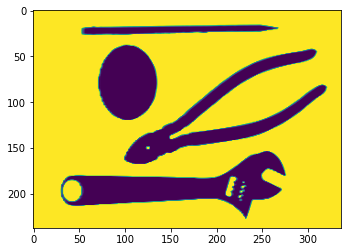

In [3]:
# example images
I = read_grayscale(join(data_path, 'tools.tiff'))
I2 = read_grayscale(join(data_path, 'Scene/CALsuburb/image_0205.jpg'))
plt.imshow(I)

In [4]:
def compute_grad(I):
    #####################
    ## Votre code ici  ##
    #####################

    hy = np.array([1,2,1])
    hx = np.array([-1,0,1])
    Ix = conv_separable(I, hy, hx)
    Iy = conv_separable(I, hx, hy)
    
    ####################
    ##      FIN        #
    ####################
    return Ix, Iy

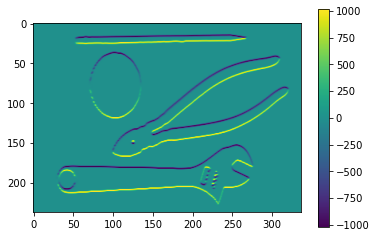

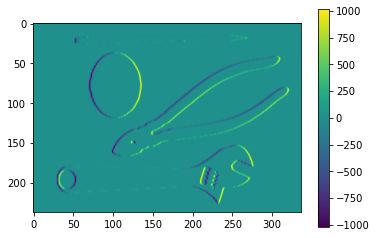

In [5]:
# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [6]:
def compute_grad_mod_ori(I):
    #####################
    ## Votre code ici  ##
    #####################

    g_x, g_y = compute_grad(I)
    
    Gn = np.sqrt(g_x**2+g_y**2)
    
    Go = compute_grad_ori(g_x, g_y, Gn, b=8)
    
    ####################
    ##      FIN        #
    ####################
    return Gn, Go

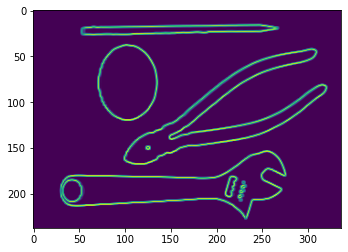

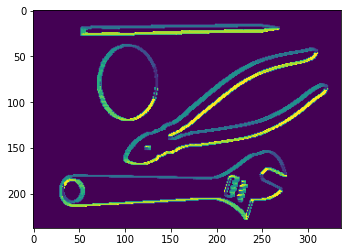

In [7]:
Gn, Go = compute_grad_mod_ori(I)
plt.imshow(Gn)
plt.show()
plt.imshow(Go)
plt.show()

In [8]:
def compute_histogram(g_n, g_o):
    """
    g_n and g_o are 4x4 matrices that contain the norm, and the discretized orientation.
    Warning: g_o can contain -1, those values should be discarded.
    """
    hist = np.zeros((8))

    #####################
    ## Votre code ici  ##
    #####################

    hist = [np.sum(g_n[np.where(g_o == h)]) for h in range(8)]
    
    ####################
    ##      FIN        #
    ####################
    return hist
  

In [9]:
def compute_sift_region(Gn, Go, mask=None):
    t_min=.5
    t_max=.2
    with_l2 = True

    patch_size = 16
    sift = np.zeros((128)) 

    if mask is not None:
        #Gn = Gn * mask
        Gn = signal.convolve2d(Gn, mask, mode='same', boundary='fill', fillvalue='0')
        
    
    idx = 0
    for k in range(0, patch_size, 4):
        for l in range(0, patch_size, 4):
            hist = compute_histogram(Gn[l:l+4,k:k+4], Go[l:l+4,k:k+4])            
            sift[idx:idx+8] = hist
            idx += 8

    norm = np.linalg.norm(sift, ord=2)
    # min thresholding on norm
    if norm <= t_min:
        return np.zeros((128))
    # l2-normalization
    if with_l2:
        sift = sift / norm
    # max thresholding on values
    sift[sift >= t_max] = t_max
    # l2-normalization
    if with_l2:
        norm = np.linalg.norm(sift, ord=2)
        sift = sift / norm
    return sift

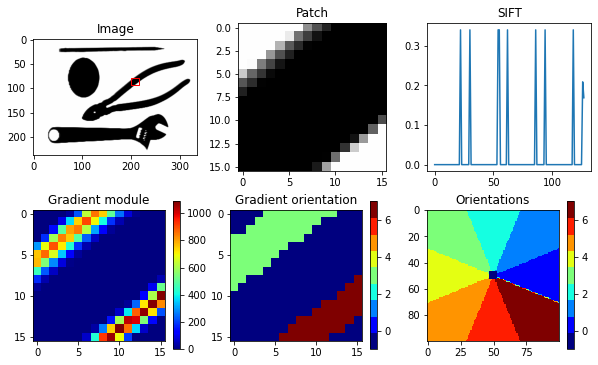

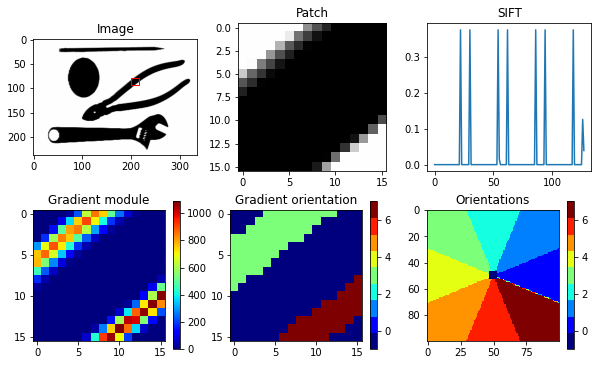

In [10]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
_ = display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=True)
_ = display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)

#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#useless = display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
#useless = display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [11]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    m = gaussian_mask()
    #####################
    ## Votre code ici  ##
    #####################
    # Ici, effectuez les calculs sur l'image globale (norme, gradients)
    Gn, Go = compute_grad_mod_ori(I)

    ####################
    ##      FIN        #
    ####################

    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #####################
            ## Votre code ici  ##
            #####################

            sifts[i, j, :] = compute_sift_region(Gn[xi:xi+16, yj:yj+16], Go[xi:xi+16, yj:yj+16], m) # TODO SIFT du patch de coordonnee (xi, yj)

            ####################
            ##      FIN        #
            ####################


    return sifts

# Compute SIFT

Le calcul durera plusieurs minutes.

In [12]:
max_images_per_class = 2  # You can change this to None to compute the whole dataset (takes quite some time)

save_path = "tmp"
dir_sc = os.path.join(data_path, 'Scene')
dir_sift = os.path.join(save_path, 'sift')
inames, ilabls, cnames = load_dataset(dir_sc, images_per_class=max_images_per_class)
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


### Questions

1)<br/>
$hx = [-1,0,1]$<br/>
$hy = [1,2,1]$

2)<br/>
1.Réduit le nombre de calcul a effectuer (on multipli hx par fonction donc 3 * nombre d epixel puis encore 3* nombrede pixel donc 6 par nombre de pixel contre 9* nombre de pixel)<br/>
2.Paralléliser le traitement?

3)<br>
1.De flouter légerement pour lisser l'image et ne garder que les contours épais/fort et pour ne pas garder le bruit lié par exemple à une texture (qui influencerais bcp le graddient et donc le sift)<br/>
2.Permet aussi de créer une "asymétrie visuelle" ici de se concentrer sur le pixel central (comme vision humaine)

4)<br>
La discrétisation permet de réduire les possibilités d'orientations et donc de mettre dans la même orientation 2 gradients "proche" (en terme de direction). On peut donc comparer les sifts de 2 images pour essayer de voir la similitude entre ces 2 images sans que celle-ci doivent iméprativement etre les mêmes. (On garde en quelques sortes l'informations sur l'orientation "principale", sa direction mais pas au degré près.) 
<br/><br/>
Et pour pourvoir faire l'histogramme, il faut qu'on est assez peu de valeur différentes pour avoir une bonne représentation du comptage (sinon on aurait que des exemple unique et un hsitogramme avec toutes les valeurs à 1). 
<br/><br/>
On peut aussi voir l'histogramme comme l'estimation de la densité du gradient dans le patch, et une discretisation trop fine fait perdre de l'information et n'est donc plus représentatif de la distribution du gradient.
<br/><br/>
ça permet aussi de rendre robuset aux perturbations (une modif va pas grandment changer l'histo)

5)<br>
Le premier seuillage sert à ramené des descripteur très petit (en norme) au descripteur nul et donc supprimme le bruit n'apportant pas d'information
<br/><br/>
Le seuillage haut (au dessus de0.2) enlève les valeurs extreme.
Les autres descripteurs sont normalisés, et on seuil les valeurs extrêmement élevé (0.2 pour un vecteur normalisé de dimension 128).<br/><br/>
Ces 2 traitements permettent de limiter les descripteurs extremes.<br/><br/>
La normalisation permet de répartir les sifts dans leur espace

6)<br>
Le principe du SIFT  permet de décrire un patch d'image comme un découpage de ce patch en petite zone qui sont défini par leur orientation générale (pas sensible à luminosité car gradient donc si modification constante, gradient ne change aps, pour la rotation, la version "classique" de sift calcule aussi le gradient moyen du patch pour que la comparaison de chaque patch se fasse par rapport à ce gradient moyen. ainsi en cas de rotation d'un patch, le gradient moyen est aussi tourner mais lrosqu'on se place dans le repère du gradient moyen, le patch n'a pas changé).
En plus, les post precessing (normalisation et seuillage) enleve du bruit (seuillage bas) et enleve les extreme (seuillage haut).
Résiste aussi aux translations. Dans une version avec centrage des patchs autour des POIs, on est encore mieux car on retrouve les POI même avec modif d'image.

7)<br/>
??
<br/>
Ici, on applique sift sur des patchs "au hasard". On pourrait imaginer qu'un visage risque d'etre couép en 2 et donc etre représenté une partie dans un patch et l'autre partie dans l'autre. 
On pourrait d'abord faier une anlyse de zone d'intéret (dectectiond e bord et de coin) puis centré nos patch sur ces points.

# Partie 2 : Dictionnaire visuel

Etrange de faire clustering puis d'ajouter un centroid 0,0 sachant que surement l'un des centroids aura pris en compte les descripteur proche de 0 donc on aura une partie des proches 0 qui ront au centroid 0 et d'autre aux centroid le pus proches de 0. <br/><br/>

Pas possible de faire un clustering en incitalisant l'un des centroid a 0 ? Ou alors en forçant un centroid à 0 non modifiable

In [13]:
from sklearn.cluster import KMeans

path_vdict = os.path.join(save_path, 'kmeans', 'vdict.npy')
os.makedirs(os.path.join(save_path, 'kmeans'), exist_ok=True)

compute_visual_dict() retourn seulement les centroid? (avec pk pas une clef indiquant le numero du centroid)

In [14]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0) 
    # remove zero vectors 
    keep = ~np.all(sift==0, axis=1) 
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]

    # TODO compute kmeans on `sift`, get cluster centers, add zeros vector, and return visual dict
    #####################
    ## Votre code ici  ##
    #####################
    kmeans = KMeans(n_clusters=n_clusters).fit(sift)
    centers = np.concatenate((kmeans.cluster_centers_, np.zeros((1,kmeans.cluster_centers_.shape[1]))), axis=0)
    
    vdict = centers
    
    ####################
    ##      FIN        #
    ####################
    return vdict


In [15]:
# Run the visual dict computation (saved the first time)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict


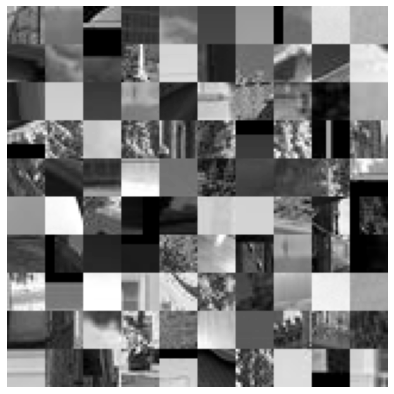

In [16]:
# Study of the dict

# choose random images
indexes = np.random.randint(0, len(inames), 30)
sifts = [sifts_list_by_image[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]

regions, sifts = get_regions_and_sifts(dir_sc, chosen_inames, sifts) # Compute SIFT and regions from 30 random images
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

# TODO visually analyze the dict through similar example regions
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

In [17]:
tree = spatial.KDTree(sifts)

In [18]:
oneNN = tree.query(vdict)

In [19]:
vdregions = regions[oneNN[1]]

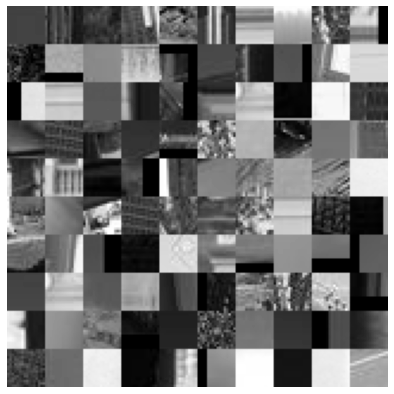

In [20]:
display_images(vdregions[:100])

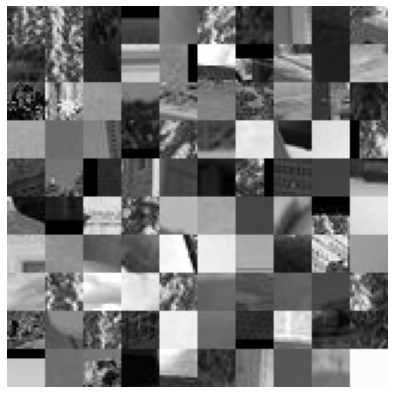

In [21]:
display_images(vdregions[-100:])

### Questions

8)<br/>
Premièrement, au niveau de la complexité, il faut réduire le nombre de descripteur différent sinon le nombre de dimension explose.<br/>?
Deuxiemement, la création de ce dictionnaire "fusionne" les descripteur proche sous un même descripteur (barycentre du cluster). Cela permet de considérer des descripteurs proches comme équivalent ce qui est très pertinent pour de la reconnaissance d'image (ou des images d'une meme classe vont etre proche dans l'espace de description).

9)<br/>
??

10)<br>
En pratique on peut faire des séries de tests en modifiant ce nombre et en prenant celui qui maximise les résultats.?? 

11)<br>
Car on ne peut simplement pas voir directement un rendu visuel de nos element du dictionnaire. On peut par contre calculer des sift d'images et récupérer les patchs ayant pour sift des valeurs proches du sift de notre element de dico. Pour voir le type d'image (ou de patch) qui correspond à ce sift. De plus, plusieurs patch peuvent avoir le même sift et ici on prend le plus proche voisin donc bcp de patch peuvent avoir le meme sift. 

12)<br>
??

# Partie 3 : BoW

Le passage au BoW est comparable au BoW en NLP. 
On décrit chaque descripteur xi comme un vecteur hi ayant que des 0 et un 1 dans la colonne k (Ck etant le mot du dico le plus proche).
On somme ensuite chaque hi pour décrire une image.<br/>
<br/>
Cela revient à remplacer chaque xi par le ci le plus proche et à compter le nombre de fois où ci apparait (equivalent TF).
Du coup, pas possible de plutot faire l'équivalent de tf-idf?
Donc en modifiant chaque descripteur par son mot du dico (equiv à lemmatiser et tokenizer) puis à compter en tfidf chaque mot (une image etant alors un doc).<br/>
<br/>
Donc ave skelarn, possible de remplacer chaque descripteur par le plus proche, puis rempalcer ces Cm par un identifiant puis appliquer un tfidfVectorizer dessus?

In [23]:
# TODO Compute BoW for an image
# indication: scipy.spatial.distance_matrix
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix

def compute_feats(vdict, image_sifts):
    """
    vdict: (num_clusters, 128): visual dictionnary containing all clusters.
    image_sifts: (H, W, 128) all sift features from the given image
    """
    # flatten sifts
    sifts = image_sifts.reshape(-1, 128)  # (N, 128)
    feats = np.zeros(vdict.shape[0])

    ##################### 
    ## Votre code ici  ##
    #####################
    # compute distance from image sifts to vdict
    tree = spatial.KDTree(vdict)
    tmp = tree.query(sifts)
    tmp = Counter(tmp[1])
    for index, value in tmp.items():
        feats[index] = value
  
    ####################
    ##      FIN        #
    ####################
    return feats

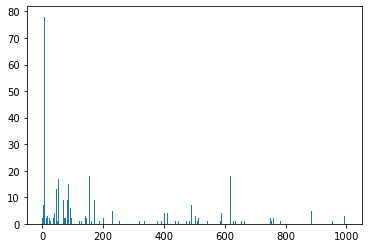

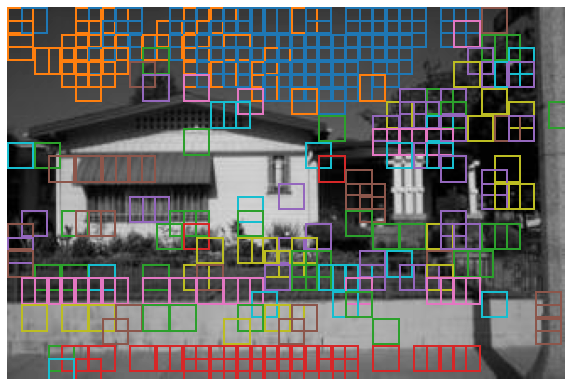

(9, 16, 16)


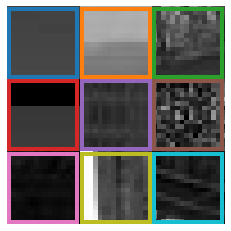

In [24]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
sift = (sift * 255).astype('uint8')
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=vdregions) # if you have vdregions, add it as input here

### Questions

13)<br/>
Z correspond à la distribution (i.e proportion=comptage normalisé) des mots du dico pour l'image considéré (equivalent d'un tf fréquentiel)

14)<br/>
??

15)<br>
On pourrait etre à plus de 1 voisin (et on pourait pondérer par distance du voisin ou classement du voisin).<br/>
<br/>
On pourrait aussi pondéré pour chaque voisin qui nous permettrai d'exprimer un descripteur comme une combinaison linaire de tout le dico (changement de repère)

16)<br>
L'intérêt est de prendre en compte la répétition d'un même Cm dans  une image (et non aps jsute la présence ou non).<br/>
<br/>
On pourrait utilsier un pooling booleen ou un pooling type tfifd comme en texte qui diviserai la somme par l'importance du descripteur pour différencier les images.

17)<br>
La normalisation  permet d'éviter qu'une image plus grande (et donc avec plus de descripteur) ai des valeurs trop élevé (puisque somme) (et inversement pour une eptite image avec peu de descripteur). ça permet d'avoir une valeur relative <br/>
<br/>
Autre normalisation ? oui on  pourrait faire normalisation L1 (correspond proprotion plus. Equiv lasso vs ridge)

# Partie 4  : SVM

**Extraction des données**

In [3]:
data = np.load("data/15_scenes_Xy.npz")
X = data["X"]
y = data["y"]

X.shape, y.shape

((4485, 1001), (4485,))

In [4]:
{c: nb for c, nb in enumerate(np.bincount(y))}

{0: 241,
 1: 360,
 2: 328,
 3: 260,
 4: 308,
 5: 374,
 6: 410,
 7: 292,
 8: 356,
 9: 215,
 10: 216,
 11: 311,
 12: 210,
 13: 289,
 14: 315}

**Standardisation des données**

In [5]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

**Séparation en train/test & validation croisée sur train**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [7]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
model = SVC()
params = {'kernel':['rbf','linear','sigmoid'], 'C':[0.1, 0.5, 1, 10]}

In [8]:
GS = GridSearchCV(model, params, cv=kfold)
GS.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 10],
                         'kernel': ['rbf', 'linear', 'sigmoid']})

**Application du meilleur modèle sur le test**

In [9]:
GS.best_estimator_.score(X_test, y_test)

0.7692307692307693